In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

In [2]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.data.all import *
from fastai2.data.core import *
from fastai2.distributed import *
from fastai2.data.transforms import *
from fastai2.vision.all import *
import gc
from itertools import product
from scipy import signal
import seaborn as sns
import mne

In [3]:
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)

from pylab import rcParams
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 300
rcParams['agg.path.chunksize'] = 10000

In [105]:
SEGMENT_SIZE      = 500_000 
TEST_SEGMENT_SIZE = 100_000

WINDOW_SIZE = 400
BS = torch.cuda.device_count() * 192
SPLITS = 5
AUGMENT_FLIP = False
XTRA_DS = False

FEAT_WINDOW = 1

assert SEGMENT_SIZE % WINDOW_SIZE == 0
assert (SEGMENT_SIZE // WINDOW_SIZE) % SPLITS == 0
SEED = 321
DATA_SUFFIX = '_clean'

p_input = Path('input')

# Read data

In [5]:
# read data
train_dtypes = {'time': np.float32, 'signal': np.float32, 'open_channels': np.int32 }
test_dtypes  = {'time': np.float32, 'signal': np.float32 }
df_train  = pd.read_csv(p_input / f'train.csv', dtype= train_dtypes)
df_test   = pd.read_csv(p_input / f'test.csv',  dtype= test_dtypes)
df_train_drift = pd.read_csv(p_input / f'train{DATA_SUFFIX}.csv', dtype= train_dtypes)
df_test_drift  = pd.read_csv(p_input / f'test{DATA_SUFFIX}.csv',  dtype= test_dtypes)
sub   = pd.read_csv(p_input / 'sample_submission.csv',  dtype={'time': np.float32})
df_train['drift'] = df_train['signal'] - df_train_drift['signal']
df_test['drift']  = df_test['signal']  - df_test_drift['signal']

In [6]:
df_train['signal'] =  df_train_drift['signal']
df_test['signal']  =   df_test_drift['signal']

In [7]:
#df_train['open_channels'][2300000:2400000][(df_train['open_channels'][2300000:2400000]==0)]=1

In [8]:
d_xtra_csvs = {
    1: ['outfinaltest10.csv',  'outfinaltest44.csv',],#  'outfinaltest78.csv',],  'outfinaltest10.csv',  'outfinaltest44.csv'],
    3: ['outfinaltest1.csv',   'outfinaltest2.csv',   'outfinaltest3.csv',   'outfinaltest4.csv', 'outfinaltest5.csv'],
    5: ['outfinaltest328.csv', 'outfinaltest534.csv', 'outfinaltest747.csv',]#, 'outfinaltest328.csv', 'outfinaltest534.csv']
}

df_train_xtra = None
for _,xtra_csvs in d_xtra_csvs.items():
    for xtra_csv in xtra_csvs:
        xx = pd.read_csv(p_input / xtra_csv , header=None,names=['time', 'signal', 'open_channels'])
        df_train_xtra = pd.concat((xx,df_train_xtra), axis=0)
df_train_xtra['drift']  = 0.
if XTRA_DS: df_train = pd.concat((df_train,df_train_xtra), axis=0)

In [9]:
train = torch.cat((torch.FloatTensor(df_train['signal'        ].values).unsqueeze(0),
                   torch.FloatTensor(df_train['drift'         ].values).unsqueeze(0),
                   torch.FloatTensor(df_train['open_channels' ].values).unsqueeze(0)))
test  = torch.cat((torch.FloatTensor(df_test ['signal'        ].values).unsqueeze(0),
                   torch.FloatTensor(df_test ['drift'         ].values).unsqueeze(0)))

# Synth

In [10]:
p_synth = Path('synth')
use_memmap = True
load_fn = np.load if not use_memmap else partial(np.lib.format.open_memmap, mode='r')

try:
    high = load_fn(str(p_synth / 'high.npy'))
    low  = load_fn(str(p_synth / 'low.npy'))
except:
    high   = pd.read_csv(p_synth / 'high.csv',header=None).values.astype('uint8')
    low    = pd.read_csv(p_synth /  'low.csv',header=None).values.astype('uint8')
    np.save(str(p_synth / 'high.npy'), high)
    np.save(str(p_synth /  'low.npy'),  low)
high = high.reshape(-1,SEGMENT_SIZE)
low  =  low.reshape(-1,SEGMENT_SIZE)

try:
    high_s = load_fn(str(p_synth / 'high-states.npy'))
    low_s  = load_fn(str(p_synth / 'low-states.npy'))
except:
    high_s   = pd.read_csv(p_synth / 'high-states.csv',header=None).values.astype('uint8')
    low_s    = pd.read_csv(p_synth /  'low-states.csv',header=None).values.astype('uint8')
    np.save(str(p_synth / 'high-states.npy'), high_s)
    np.save(str(p_synth /  'low-states.npy'),  low_s)
high_s = high_s.reshape(-1,SEGMENT_SIZE)
low_s  =  low_s.reshape(-1,SEGMENT_SIZE)
low_s_to_oc  = np.array([0,0,0,0,1,1]).astype(np.uint8)   # 4,5   OC
high_s_to_oc = np.array([0,0,1,0,0,1,1]).astype(np.uint8) # 2,5,6 OC

In [11]:
high_s

memmap([[5, 5, 5, ..., 2, 1, 2],
        [5, 5, 5, ..., 2, 2, 2],
        [5, 5, 5, ..., 1, 1, 2],
        ...,
        [5, 5, 5, ..., 5, 5, 5],
        [5, 5, 5, ..., 2, 2, 2],
        [5, 5, 5, ..., 1, 1, 1]], dtype=uint8)

In [12]:
def get_synth_segment_y(states,max_channels,size=SEGMENT_SIZE):
    y = np.zeros((size,1+max_channels),dtype=np.uint8)
    states,states_to_oc = {'l':(low_s,low_s_to_oc), 'h':(high_s,high_s_to_oc)}[states]
    for ii,i in enumerate(np.random.choice(states.shape[0],max_channels,replace=False)):
        o = np.random.randint(1+SEGMENT_SIZE-size)
        ss = states[i,o:o+size]
        y[:,0]   += states_to_oc[ss]
        y[:,1+ii] = ss
    y[:,0] = np.clip(y[:,0], 0, 10)
    return y[:,0]
y=get_synth_segment_y('h',10,SEGMENT_SIZE//5)
np.bincount(y,minlength=11)
# (low,1), (low,1), (high,1), (high,3), (high,10), (high,5), (high,1), (high,3), (high,5), (high,10)

array([    0,     5,   112,   674,  2974,  8700, 18519, 26906, 24851,
       13675,  3584])

In [13]:
for i in range(10): print(np.bincount(get_synth_segment_y('l',5,SEGMENT_SIZE//5),minlength=11))


[90504  9316   180     0     0     0     0     0     0     0     0]
[78170 17717  2976  1137     0     0     0     0     0     0     0]
[90369  9631     0     0     0     0     0     0     0     0     0]
[86560 13070   370     0     0     0     0     0     0     0     0]
[90546  9452     2     0     0     0     0     0     0     0     0]
[86278 12923   799     0     0     0     0     0     0     0     0]
[88404 11596     0     0     0     0     0     0     0     0     0]
[86555 13441     4     0     0     0     0     0     0     0     0]
[88383 11150   467     0     0     0     0     0     0     0     0]
[88367 11205   428     0     0     0     0     0     0     0     0]


torch.Size([3, 50, 500000])


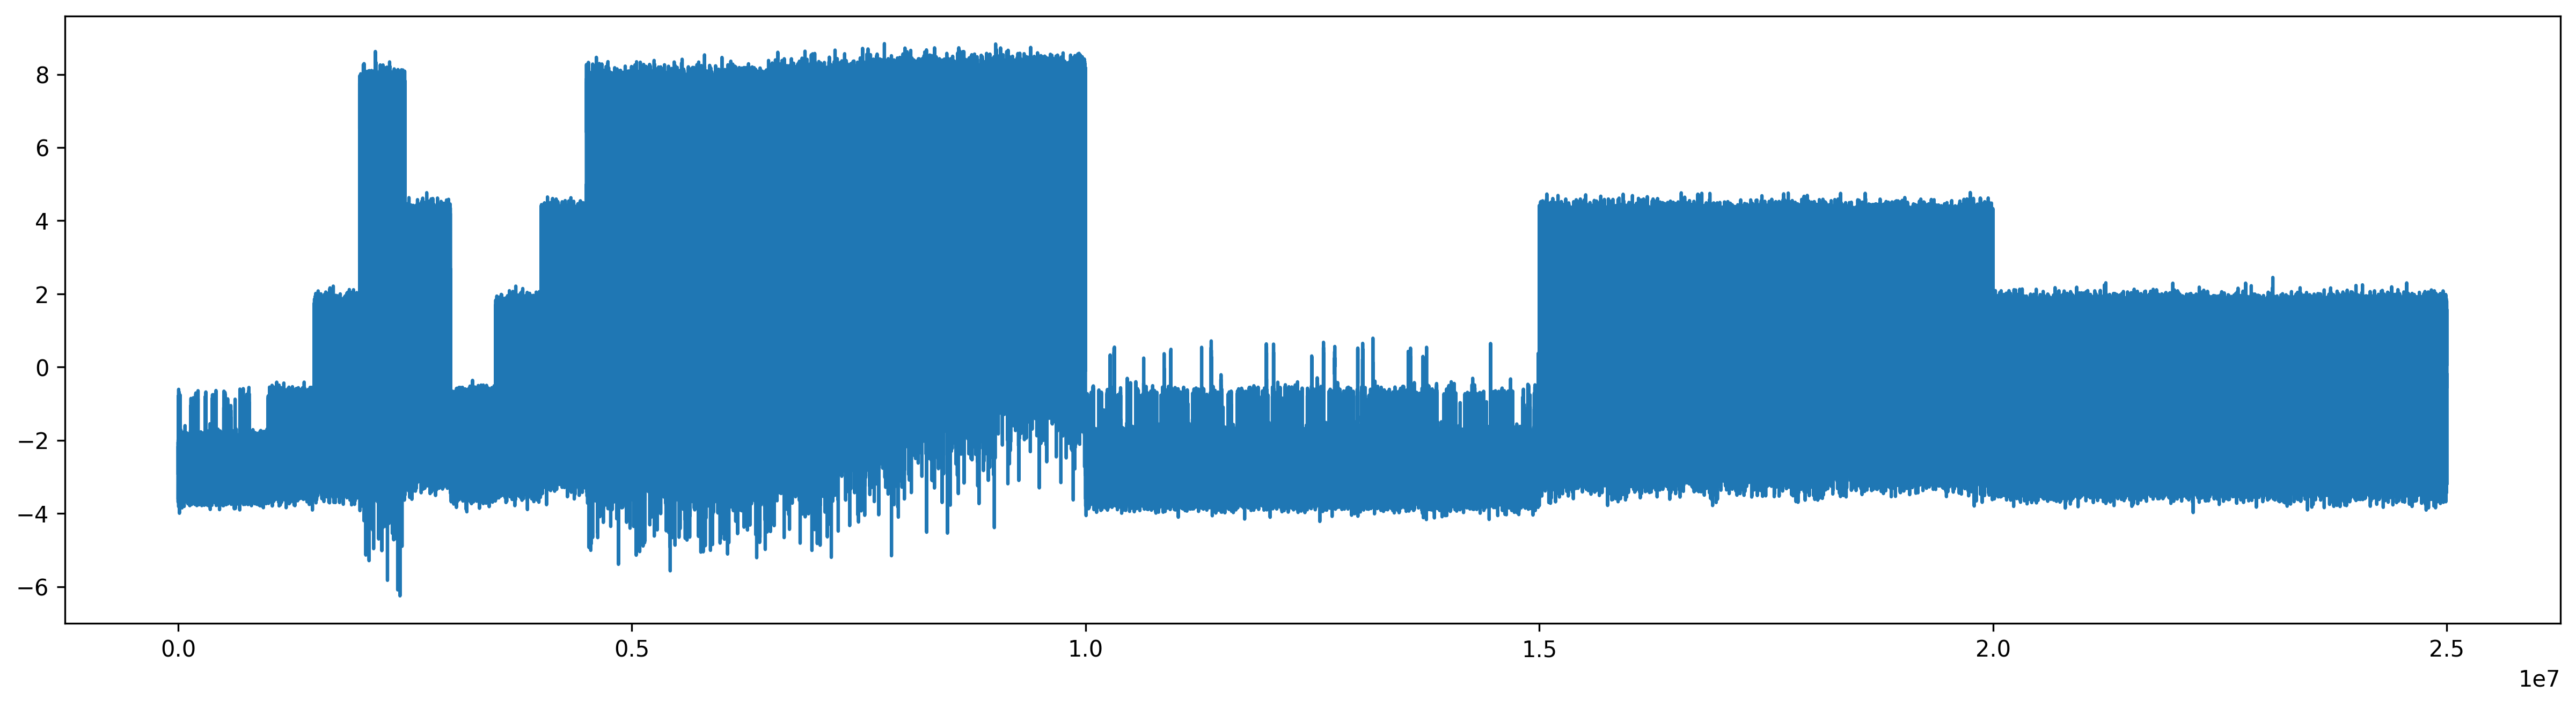

In [14]:
# -0.12838999,49.9232689,1.73201717
def get_synth_segment_xy(states,max_channels,size=SEGMENT_SIZE):
    kernel = tensor([-1.6590e-03, -1.1617e-04, -1.0344e-03,  8.4467e-04, -9.7054e-04,
              1.4413e-03,  6.5739e-03,  2.8979e-02,  1.2115e+00, -1.0717e-03,
             -3.8138e-03,  6.0101e-04,  1.2317e-04,  3.1660e-03, -8.8741e-04,
              3.2797e-04,  2.5820e-03, -2.3032e-03])
    dim_k = kernel.numel()
    bias = tensor([-5.5336 if max_channels >= 10 else -2.7708])
    y = Tensor(get_synth_segment_y(states,max_channels,size))
    y_padded = torch.zeros(y.shape[0]+dim_k-1)
    cc = (dim_k-1)//2
    y_padded[cc:cc+y.shape[0]] = y.float()
    y_padded = y_padded.view(1,1,-1)
    x = (F.conv1d(y_padded,kernel.view(1,1,-1)).flatten() + bias).to(y.device)
    ac_weight,ac_freq,ac_phase = -0.12838999,50+0.2*(torch.rand(1)-0.5),2*math.pi*torch.rand(1)
    x_range = torch.arange(x.shape[0]).float().to(x.device)
    wave = (ac_weight * torch.sin( x_range * 2*math.pi/10000 * ac_freq + ac_phase))
    x += wave
    std = [None,0.238,None,0.267,None,0.2861,None,None,None,None,0.406][min(max_channels,10)]
    x += std * torch.randn(x.numel())
    return x,y
segment_types=[('l', 1),('l', 1),('h', 1),('h', 3),('h',10),('h', 5),('h', 1),('h', 3),('h', 5),('h',10),
               ('h',10),('h',10),('h',10),('h',11),('h',11),('h',12),('h',13),('h',13),('h',14),('h',14),
               ('l', 3),('l', 3),('l', 3),('l', 3),('l', 3),('l', 3),('l', 3),('l', 3),('l', 3),('l', 3),
               ('h', 5),('h', 5),('h', 5),('h', 5),('h', 5),('h', 5),('h', 5),('h', 5),('h', 5),('h', 5),
               ('h', 3),('h', 3),('h', 3),('h', 3),('h', 3),('h', 3),('h', 3),('h', 3),('h', 3),('h', 3)]

train_s = torch.empty(3,len(segment_types),SEGMENT_SIZE)
train_s[:] = np.nan
for i,segment in enumerate(segment_types):
    train_s[0,i],train_s[2,i] = get_synth_segment_xy(*segment)
plt.plot(train_s[0].flatten())
print(train_s.shape)

# Filter 

def filter(x):
    return mne.filter.notch_filter(x.numpy().astype('float64'),10000,50.0)
train[0,:]=Tensor(filter(train[0,:]))
test[0,:] =Tensor(filter( test[0,:]))

In [15]:
train_s = train_s.view(train_s.shape[0],-1,SEGMENT_SIZE)
train   =   train.view(  train.shape[0],-1,SEGMENT_SIZE)
test    =    test.view(   test.shape[0],-1,TEST_SEGMENT_SIZE)

In [16]:
train = train[:,[0,1,2,3,4,5,6,8,9],:]

In [17]:
train_s.shape,train.shape,test.shape

(torch.Size([3, 50, 500000]),
 torch.Size([3, 9, 500000]),
 torch.Size([2, 4, 500000]))

# EDA

In [ ]:
means = FloatTensor([-2.73135856, -1.49979538, -0.26823219, 0.963331,   2.19489419, 3.42645737,
                    np.nan,        np.nan,    np.nan,     np.nan,     np.nan])

In [ ]:
from scipy.ndimage.interpolation import shift


In [ ]:
sf = 1
x = F.interpolate(train[0,0,:].view(1,1,-1),scale_factor=sf).squeeze()
y = F.interpolate(train[2,0,:].view(1,1,-1),scale_factor=sf).squeeze()
x,y = train[0,0,:],train[2,0,:]
#x = x[1:] - x[:-1]
w = means[1]-means[0]
b = means[0]
n = x-(w*y+b)

s0,s1=7225,7240
ss=slice(s0*sf,s1*sf)
plt.plot(x[ss])
plt.plot(y[ss])
x.shape
from scipy.ndimage.interpolation import shift

for s in np.linspace(0,1,10):
    noise = x - (w*shift(y,s,order=3) + b)
    plt.plot(noise[ss])

def _noise(params):
    b,s,w,w1,w2,b1,b2 = params
    return x - w*(shift(y,s,order=1)+b) - w1*(shift(y,s+1,order=1)+b1) - w2*(shift(y,s+2,order=1)+b2)

def noise_std(params): return np.std(_noise(params))
for ss in [[4,9],[4],[9],[0],[1],[0,1],[2],[6],[2,6]]:
    x,y = train[0,ss,:].flatten().numpy(),train[2,ss,:].flatten().numpy()
    res = scipy.optimize.minimize(noise_std,([0.]*7),method='COBYLA', options={'disp':True},)
    print(ss,res.x,noise_std(res.x))

In [ ]:
train.shape

In [ ]:
def get_hist(y):
    SS = y.shape[1]
    l_train = y.shape[0]*SS
    train_channels_in_segment=torch.zeros((y.shape[0],11))
    for i,s in enumerate(range(0,l_train,SS)):
        train_channels_in_segment[i] = torch.histc(y[i,:],11,0,11)
    return train_channels_in_segment.long()

train_channels_in_segment = get_hist(train[2])
train_channels_in_segment//5

In [ ]:
si = train[0,:,:].flatten()#  + train[1,:,:].flatten()
oc = train[2,:,:].flatten()
plt.subplot(2, 1, 1)
plt.plot(si)
plt.subplot(2, 1, 2)
plt.plot(oc)

In [ ]:
means = FloatTensor([[-2.73135856, -1.49979538, -0.26823219, 0.963331,   2.19489419, 3.42645737,
                    np.nan,        np.nan,    np.nan,     np.nan,     np.nan],
                    [-5.49309926, -4.25506493, -3.0170306, -1.77899627,  -0.54096195, 0.69707238,
                     1.93510671,  3.17314104, 4.41117536, 5.64920969, 6.88724402]])

In [ ]:
noises = []
si = train[0,[3],:].flatten().clone()
oc = train[2,[3],:].flatten().long()
plt.plot(si)
for i in range(11):
    noise = si[oc==i]-means[1][i]
    plt.plot(noise)
    noises.append(noise)
    print(noise.std())

#si = train[:,[0,1,2,3,4,5,6,8,9],:]

In [ ]:
means[0]

In [ ]:
si = train[0,[3],:].flatten().clone()
oc = train[2,[3],:].flatten().long()
noise = si.clone()
for i,ocs in enumerate(means[0].numpy()):
    if np.isnan(ocs): break
    noise -= (oc == i) * ocs
plt.plot(noise)

In [ ]:
MICROSEGMENT_SIZE = 100_000

In [ ]:
noise

In [ ]:
plt.imshow(noise[:MICROSEGMENT_SIZE*1].view(-1,1000).clamp(-1,1))

In [ ]:
si.shape

In [ ]:
def convert_params(params):
    ac_weight,ac_freq,ac_phase = params
    ac_freq =  Tensor([ac_freq]).to(x_range.device)
    return ac_weight,ac_freq,ac_phase
def residual(params,return_corrected=False):
    ac_weight,ac_freq,ac_phase = convert_params(params)
    wave = (ac_weight * torch.sin( x_range * 2*math.pi/10000 * ac_freq + ac_phase))
    if return_corrected: return wave.cpu()
    err = (wave-noise_s).abs().sum().cpu().numpy()
    del wave
    return err

In [ ]:
import scipy.fftpack

# Number of samplepoints
N = noise_s.numel()
# sample spacing
T = 1.0 / 10000
x = np.linspace(0.0, N*T, N)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
i = 1
#noise = train[0,[4,9],:].flatten().clone()

mss = range(1) #len(noise)//MICROSEGMENT_SIZE)
plt.figure(figsize=(20,10*len(mss)))

for ms in mss:
    ac_weight,ac_freq,ac_phase = 0.2,50,1
    noise_s = noise[MICROSEGMENT_SIZE*ms:(ms+1)*MICROSEGMENT_SIZE].cuda()
    x_range = torch.arange(len(noise_s)).cuda()
    res = scipy.optimize.minimize(residual, (0.1,50.,0), method="Powell")
    noise_f = noise_s.cpu()-residual(res.x,return_corrected=True)
    print(res.x,noise_s.std(), noise_f.std())
    
    for y in [noise_s,noise_f]:
        y = y.cpu().numpy()
        yf = scipy.fftpack.fft(y)
        yff = 2.0/N * np.abs(yf[:N//2])
        #print(xf[yff.argmax()])
        plt.subplot(2*len(mss),1,i)
        plt.plot(xf, yff)
        i += 1
plt.plot()

In [ ]:
y,x = oc[:MICROSEGMENT_SIZE],si[:MICROSEGMENT_SIZE]-residual(res.x,return_corrected=True)
plt.plot(y+8)
plt.plot(si[:MICROSEGMENT_SIZE])
plt.plot(x)

In [ ]:
means[0,0]

In [ ]:
dim_k = 18
k = nn.Parameter(torch.zeros(dim_k))
b = nn.Parameter(means[0,0])
b = nn.Parameter(Tensor([-2.7708]))
y_padded = torch.zeros(y.shape[0]+dim_k-1)
cc = (dim_k-1)//2
y_padded[cc:cc+y.shape[0]] = y.float()
y_padded = y_padded.view(1,1,-1)
torch.nn.init.uniform_(k)
y_padded,x,k,b

In [ ]:
lr = 0.001

In [ ]:
kernel = tensor([-1.6590e-03, -1.1617e-04, -1.0344e-03,  8.4467e-04, -9.7054e-04,
          1.4413e-03,  6.5739e-03,  2.8979e-02,  1.2115e+00, -1.0717e-03,
         -3.8138e-03,  6.0101e-04,  1.2317e-04,  3.1660e-03, -8.8741e-04,
          3.2797e-04,  2.5820e-03, -2.3032e-03])

In [ ]:
for i in progress_bar(range(10000)):
    yy = F.conv1d(y_padded,k.view(1,1,-1)).flatten() + b#[y]
    #yy = F.conv1d(y_padded,kernel.view(1,1,-1)).flatten() + bias#[y]
    #break
    loss = nn.MSELoss()(yy,x)
    loss.backward()
    if i % 1000 == 0: print(loss,k,b)
    with torch.no_grad():
        #k -= lr * k.grad
        b -= 1*lr * b.grad
        # Manually zero the gradients after updating weights
        #k.grad.zero_()
        b.grad.zero_()
print(b,k)

In [ ]:
k,b

In [ ]:
yy=yy.detach()
yy,x
plt.plot(k.detach())

In [ ]:
yy,x

In [ ]:
plt.plot(yy)
plt.plot(x)
plt.plot(yy-x)
(yy-x).std(),noise_f.std(), noise_s.std()

In [ ]:
naive_x = means[1][y]
plt.plot(naive_x)
naive_x

In [ ]:
plt.plot(x-yy)
plt.plot(noise_f)

In [ ]:
(naive_x-yy).std()

In [ ]:
best_noise = yy.detach()-x
synth_noise = 0.4069*torch.randn(best_noise.numel())
sns.distplot(best_noise,bins=200)
sns.distplot(synth_noise,bins=200)


In [ ]:

stds_per_ocs = ["", 0.2499, "", 0.2713,"", 0.2870,"","","","",0.4127  ]
n = 0.115 *torch.randn(best_noise.numel())
for i in range(11):
    n += 0.110 *torch.randn(best_noise.numel())
    print(i,n.std(),stds_per_ocs[i])

In [ ]:
0.25 = 1 * oc + b
0.27 = 1.7259 * oc + b
0.4122 = 3.3010 * oc + b
0.2897 = 2.4322 * oc 

In [ ]:
# (low,1), (low,1), (high,1), (high,3), (high,10), (high,5), (high,1), (high,3), (high,5), (high,10)
for i in range(10):
    si = train[0,i].clone()
    oc = train[2,i].long()
    mean_std_idx = 1  if ((i == 4) or (i==9)) else 0
    naive_x = means[mean_std_idx][oc]
    print(i,(naive_x-si).std(), [(naive_x[oc==occ]-si[oc==occ]).std() for occ in range(11)])

In [ ]:
(Parameter containing:
 tensor([-1.6590e-03, -1.1617e-04, -1.0344e-03,  8.4467e-04, -9.7054e-04,
          1.4413e-03,  6.5739e-03,  2.8979e-02,  1.2115e+00, -1.0717e-03,
         -3.8138e-03,  6.0101e-04,  1.2317e-04,  3.1660e-03, -8.8741e-04,
          3.2797e-04,  2.5820e-03, -2.3032e-03], requires_grad=True),
 Parameter containing:
 tensor([-5.5336], requires_grad=True))

### err = np.inf
for ac_weight in progress_bar(np.linspace(0,0.1,100)):
    for ac_freq in np.linspace(-10,10,100):
        for ac_phase in np.linspace(-10,10,10):
            n_err = residual((ac_weight,ac_freq,ac_phase))
            if n_err < err:
                err = n_err
                res.x = (ac_weight,ac_freq,ac_phase)
noise_f = residual(res.x,return_corrected=True)
print(res.x,noise_s.std(), noise_f.std())

In [ ]:
plt.subplot(2, 1, 1)
plt.imshow(noise_s.view(-1,1000).cpu())
plt.subplot(2, 1, 2)
plt.imshow(noise_f.view(-1,1000).cpu())

In [ ]:
sns.distplot(noise_f)

In [ ]:
residual((-0.12838999,49.9232689,1.73201717),return_corrected=True).cuda()

In [ ]:
import scipy.fftpack

# Number of samplepoints
N = noise_s.numel()
# sample spacing
T = 1.0 / 10000
x = np.linspace(0.0, N*T, N)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
noise_ss = noise_s - residual((-0.12838999,49.9232689,1.73201717),return_corrected=True).cuda()
for i,y in enumerate([noise_s,noise_f]):
    y = y.cpu().numpy()
    yf = scipy.fftpack.fft(y)
    yff = 2.0/N * np.abs(yf[:N//2])
    print(xf[yff.argmax()],np.angle(yf[yff.argmax()]))
    plt.subplot(2,1,i+1)
    plt.plot(xf, yff)

In [ ]:
noise_s.std(), residual(res.x,return_corrected=True).std()

In [ ]:
si = train[0,[0,1,2,3,5,6,7],:].flatten()
oc = train[2,[0,1,2,3,5,6,7],:].flatten().long()
noises = []

for i in range(11):
    noise = si[oc==i]-means[0][i]
    plt.plot(noise)
    noises.append(noise)
    print(noise.std())

#si = train[:,[0,1,2,3,4,5,6,8,9],:]
noises[0]

In [ ]:
means

In [ ]:
train.shape

plt.figure(figsize=(10,40))
plt.subplot(13,1,1)
plt.plot(oc)
plt.subplot(13,1,2)
plt.plot(si)
SS = 500000

for i in range(11):
    plt.subplot(13,1,i+3)
    ss = si.clone()
    ss[oc != i] = Tensor([np.nan])
    ss[0] =  si.min()
    ss[-1] = 9
    
    for s in range(10):
        sss = slice(s*SS,(s+1)*SS)
        v = si[sss][oc[sss] == i]
        
        mean,std = v.mean(), v.std()
        
        if ~torch.isnan(mean):
            plt.annotate(f'{mean.item():0.02f}',xy=(SS/2+s*SS, 7), xycoords='data',
                        horizontalalignment='center', verticalalignment='bottom')

        if ~torch.isnan(std):
            plt.annotate(f'{std.item():0.02f}',xy=(SS/2+s*SS, -5), xycoords='data',
                        horizontalalignment='center', verticalalignment='bottom')
        if s==5: print(f"{std.item():0.02f},",end="")
            
    plt.plot(ss)

In [ ]:
#sns.distplot(si[:SS])

# Normalize

In [18]:
FEAT_WINDOW

1

In [19]:
def build_lag_lead(x,DIM):
    if DIM < 2: return x.unsqueeze(-1)
    w = DIM//2
    assert w > 1
    ws = x.shape[-1]
    r = math.ceil(w/ws) + 1
    x_lead  = x.repeat(1,1,r)[...,:ws+w-1]
    x_lag   = x.repeat(1,1,r).flip((2))[...,:ws+w-1]
    lead,lag=x_lead.unfold(2,w,1), x_lag.unfold(2,w,1).flip((2))
    lag[...,0] = lag[...,0]**2
    return torch.cat((lead,lag),dim=3)
train_s = build_lag_lead(train_s,FEAT_WINDOW)
train   = build_lag_lead(  train,FEAT_WINDOW)
test    = build_lag_lead(   test,FEAT_WINDOW)
train_s.shape,train.shape,test.shape

(torch.Size([3, 50, 500000, 1]),
 torch.Size([3, 9, 500000, 1]),
 torch.Size([2, 4, 500000, 1]))

In [20]:
train[0].shape

torch.Size([9, 500000, 1])

In [21]:
signal_mean, signal_std = train[0].mean(),train[0].std()
train_s[0] = ((train_s[0] - signal_mean) / signal_std)
train[0]   = ((  train[0] - signal_mean) / signal_std)
test[0]    = ((   test[0] - signal_mean) / signal_std)
train,test

(tensor([[[[-1.1047e+00],
           [-1.1416e+00],
           [-9.6870e-01],
           ...,
           [-1.1794e+00],
           [-1.1095e+00],
           [-1.1267e+00]],
 
          [[-1.2395e+00],
           [-1.3025e+00],
           [-1.2861e+00],
           ...,
           [-9.7507e-01],
           [-7.2089e-01],
           [-9.7507e-01]],
 
          [[-7.0330e-01],
           [-5.6401e-01],
           [-7.8852e-01],
           ...,
           [-5.9518e-01],
           [-5.8245e-01],
           [-6.7433e-01]],
 
          ...,
 
          [[-5.5962e-01],
           [-6.1117e-01],
           [-5.1251e-01],
           ...,
           [-5.7232e-01],
           [-8.2568e-01],
           [-5.3666e-01]],
 
          [[ 1.3336e+00],
           [ 1.2625e+00],
           [ 1.4481e+00],
           ...,
           [ 6.3240e-01],
           [ 5.7308e-01],
           [ 1.9312e-01]],
 
          [[ 2.5224e+00],
           [ 2.6655e+00],
           [ 2.4100e+00],
           ...,
           [ 1

# Dataset and splits

In [22]:
split = 0
split_size = SEGMENT_SIZE//WINDOW_SIZE//SPLITS
windows_per_segment = np.arange(SEGMENT_SIZE//WINDOW_SIZE)
valid_split_idx = split*split_size + np.arange(split_size)
all_segments = range(train.shape[1])
valid_idx = list(product(range(50) if XTRA_DS else all_segments,valid_split_idx))
train_idx = list(product(all_segments,windows_per_segment))
train_idx = list(sorted(set(train_idx).difference(set(valid_idx))))

In [23]:
windows_per_segment,split_size

(array([   0,    1,    2, ..., 1247, 1248, 1249]), 250)

In [24]:
# SYNTH
#train_idx = list(product(range(len(all_segments)*10),splits_per_segment))
#valid_idx = list(product([0, 1, 2, 3, 4, 5, 6, 8, 9],splits_per_segment))

In [141]:
class IonDataset(torch.utils.data.Dataset):
    def __init__(self, data,idx=None,jitter=False,shift=0):
        super().__init__()
        self.data, self.jitter,self.shift = data, jitter, shift
        self.segment_size = data.shape[-2]
        self.idx = ifnone(idx,list(product(range(self.data.shape[1]),np.arange(self.segment_size//WINDOW_SIZE))))
        self.n_inp = 1
        self.has_y = self.data.shape[0] == 3
    def __len__(self): return len(self.idx)
    def __getitem__(self, idx):
        s,o=self.idx[idx]
        jitter = 0
        if self.jitter:
            os,oe = 0,0
            if ((s,(o-1)) in self.idx): os = -WINDOW_SIZE//2
            if ((s,(o+1)) in self.idx): oe =  WINDOW_SIZE//2
            jitter = torch.randint(os,oe,(1,)).item()
        so,se = jitter+o*WINDOW_SIZE,jitter+(o+1)*WINDOW_SIZE
        assert (so < self.segment_size) and (se <= self.segment_size)
        so,se = so + self.shift, se + self.shift
        if se > self.segment_size:
            ss = torch.arange(so,se) % self.segment_size
        else:
            ss = slice(so,se)
        x =  self.data[0,s,ss,:]
        if self.has_y: y_open_channels = self.data[2,s:s+1,ss,0].long()
        return (x,y_open_channels) if self.has_y else (x,)

train_ds = IonDataset(train_s, None, jitter=True)
valid_ds = IonDataset(train, None)
test_ds  = IonDataset(test)
test_ds[249][0].shape

torch.Size([400, 1])

In [ ]:
#train_ds = IonDataset((train, train_channels_in_segment), train_idx, jitter=False, synth=True)
len(train_ds)
x = torch.empty((len(train_ds),train_ds[0][0].shape[0]))
print(x.shape)
for i in range(len(train_ds)): x[i] = train_ds[i][0].squeeze()
plt.plot(x.flatten())

In [142]:
train_dl = DataLoader(train_ds, BS,    shuffle=True,  num_workers=8, pin_memory=True)
valid_dl = DataLoader(valid_ds, BS,    shuffle=False, num_workers=8, pin_memory=True)
test_dl  = DataLoader(test_ds,  BS//2, shuffle=False, num_workers=8, pin_memory=True)

# Model 

In [27]:
# detail 
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        f_out = 256

        self.LSTM0 = nn.LSTM(input_size=FEAT_WINDOW, hidden_size=256, num_layers=1, batch_first=True, 
                            bidirectional=True, dropout=0.)
        self.LSTM  = nn.LSTM(input_size=256*2, hidden_size=256, num_layers=4, batch_first=True, 
                            bidirectional=True, dropout=0.5)
        self.fc = nn.Linear(f_out*2, 11)
        
        self.debug = False

    def forward(self, x):
        x, _ = self.LSTM0(x)
        x, _ = self.LSTM(x)
        return self.fc(x),x

In [28]:
dls = DataLoaders(train_dl, valid_dl, test_dl, device=default_device())

model = ReformerLM(
    num_tokens = 11,
    dim = dim,
    depth = depth,
    max_seq_len = WINDOW_SIZE,
    heads = heads,
    lsh_dropout = lsh_dropout,
    bucket_size=bucket_size,
    causal = False,
    use_full_attn = False,
    fixed_position_emb = False,
    n_hashes = 4,
)
model.token_emb = nn.Linear(1,dim)

In [29]:
model = Classifier()
model

Classifier(
  (LSTM0): LSTM(1, 256, batch_first=True, bidirectional=True)
  (LSTM): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=11, bias=True)
)

# Loss 

In [30]:
def softf1_loss(logits,true,weights=None):
    eps=0
    # 96 4000 11, 96 4000 1 
    n_classes = logits.shape[-1]
    weights = ifnone(weights,torch.ones((n_classes,),dtype=logits.dtype,device=logits.device))
    y_pred = logits.view(-1,n_classes).softmax(dim=-1)             
    y_true = F.one_hot(true.flatten(), n_classes).to(torch.float32)

    tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

    precision = tp / (tp + fp + eps )
    recall = tp / (tp + fn + eps )

    f1 = 2* (precision*recall) / (precision + recall + eps)
    f1 = f1.clamp(0,1) * weights
    f1 = f1[~torch.isnan(f1)].mean()
    return 1-f1

class SoftF1Loss(Module):
    def __init__(self, weight=None): self.weight = weight
    def forward(self, output, target): return softf1_loss(output, target, self.weight)

class LabelSmoothingCE(Module):
    def __init__(self, eps:float=0.65, reduction='mean'): self.eps,self.reduction = eps,reduction

    def forward(self, output, target):
        c = output.size()[-1]
        output = output.permute(0,2,1) # => B C S
        target = target.squeeze(1)     # => B S
        log_preds = F.log_softmax(output, dim=1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=1)
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, reduction=self.reduction)

class DriftChannelsLoss(Module):
    def __init__(self, losses, weights=None):
        self.losses, self.weights = losses, ifnone(weights, [1.] * len(losses))
        self.hist = torch.ones((11,))
    def __call__(self, input:Tensor, target:Tensor, **kwargs):
        i_open_channels, _ = input
        t_open_channels    = target
        self.hist = self.hist.to(device=t_open_channels.device) + t_open_channels.flatten().float().histc(11,0,11)
        weight = self.hist.sum() / self.hist
        loss = L([l(i_open_channels,t_open_channels)*w for l,w in zip(self.losses, self.weights)]).sum()
        return loss

# Metrics

In [31]:
import sklearn.metrics as skm

# Cell
class OpenChannelsAccumMetric(Metric):
    "Stores predictions and targets on CPU in accumulate to perform final calculations with `func`."
    def __init__(self, func, dim_argmax=None, sigmoid=False, thresh=None, to_np=False, invert_arg=False,
                 flatten=True, metric_name=None, **kwargs):
        store_attr(self,'func,dim_argmax,sigmoid,thresh,flatten,metric_name')
        self.to_np,self.invert_args,self.kwargs = to_np,invert_arg,kwargs

    def reset(self): self.targs,self.preds = [],[]

    def accumulate(self, learn):
        t,p = learn.y,learn.pred[0] #learn.y[1],learn.pred[1]
        pred = p.argmax(dim=self.dim_argmax) if self.dim_argmax else p
        if self.sigmoid: pred = torch.sigmoid(pred)
        if self.thresh:  pred = (pred >= self.thresh)
        #pred = p.round()
        targ = t
        pred,targ = to_detach(pred),to_detach(targ)
        if self.flatten: pred,targ = flatten_check(pred,targ)
        self.preds.append(pred)
        self.targs.append(targ)

    @property
    def value(self):
        if len(self.preds) == 0: return
        preds,targs = torch.cat(self.preds),torch.cat(self.targs)
        if self.to_np: preds,targs = preds.numpy(),targs.numpy()
        return self.func(targs, preds, **self.kwargs) if self.invert_args else self.func(preds, targs, **self.kwargs)

    @property
    def name(self):
        return ifnone(self.metric_name,self.func.func.__name__ if hasattr(self.func, 'func') else  self.func.__name__)

# Cell
def skm_to__open_channels_fastai(func, is_class=True, thresh=None, axis=-1, sigmoid=None, **kwargs):
    "Convert `func` from sklearn.metrics to a fastai metric"
    dim_argmax = axis if is_class and thresh is None else None
    sigmoid = sigmoid if sigmoid is not None else (is_class and thresh is not None)
    return OpenChannelsAccumMetric(func, dim_argmax=dim_argmax, sigmoid=sigmoid, thresh=thresh,
                       to_np=True, invert_arg=True, **kwargs)

def MF1Score(axis=-1, labels=None, pos_label=1, average='binary', sample_weight=None, **kwargs):
    "F1 score for single-label classification problems"
    return skm_to__open_channels_fastai(skm.f1_score, axis=axis,
                         labels=labels, pos_label=pos_label, average=average, sample_weight=sample_weight, **kwargs)

def A(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = inp[0],targ#inp[1], targ[1]
    pred,targ = flatten_check(pred.argmax(dim=axis), targ)
    return (pred == targ).float().mean()

In [32]:
mets = [MF1Score(labels=[l],average='macro', metric_name=f"f1_{l}") for l in range(11)]
mets.extend([MF1Score(labels=list(range(11)),average='macro', metric_name=f"f1"), A])

# Train

In [33]:
learn = None
gc.collect()
torch.cuda.empty_cache()
learn = Learner(dls,model,loss_func=DriftChannelsLoss([LabelSmoothingCE(0.65)]),
                opt_func=RMSProp,metrics=mets, moms=None,)

#learn.callbacks.extend([F1Metric(learn)])

learn.to_parallel()#.to_fp16()
learn.model.debug = True
summary = learn.summary()
learn.model.debug = False
match = re.search(r'Total trainable params: ([0-9,]+)', summary)
model_params = int(match.group(1).replace(",",""))
print(summary)

Classifier (Input shape: ['384 x 400 x 1'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['384 x 400 x 512',  530,432    True      
________________________________________________________________
LSTM                 ['384 x 400 x 512',  6,307,840  True      
________________________________________________________________
Linear               384 x 400 x 11       5,643      True      
________________________________________________________________

Total params: 6,843,915
Total trainable params: 6,843,915
Total non-trainable params: 0

Optimizer used: <function RMSProp at 0x7fa457d065e0>
Loss function: DriftChannelsLoss()

Callbacks:
  - TrainEvalCallback
  - ParallelTrainer
  - Recorder
  - ProgressCallback


In [34]:
modelname = 'lstm6843915_t62500_v11250_BS384_SS500000_WS400_FW1_cv0.9423_clean_synth'
try:
    learn.load(modelname, strict=False)
    print(f"Loaded {modelname}")
except:
    print(f"Failed to load {modelname}")

Loaded lstm6843915_t62500_v11250_BS384_SS500000_WS400_FW1_cv0.9423_clean_synth


In [ ]:
#lr_min, lr_steep=learn.lr_find()

In [ ]:
#learn.fit_flat_cos(100,lr=1e-3)

In [ ]:
learn.fit_flat_cos(100,1e-3,pct_start=0.5)

In [ ]:
learn.model.debug

In [39]:
learn.loss_func=DriftChannelsLoss([LabelSmoothingCE(0.80)])

In [40]:
learn.fit_flat_cos(10,1e-4)#,pct_start=0.5)

epoch,train_loss,valid_loss,f1_0,f1_1,f1_2,f1_3,f1_4,f1_5,f1_6,f1_7,f1_8,f1_9,f1_10,f1,A,time
0,2.266448,2.266251,0.998671,0.996350,0.983559,0.982003,0.972973,0.950358,0.888991,0.894700,0.897858,0.898852,0.900218,0.942230,0.969977,01:54
1,2.266511,2.266243,0.998682,0.996353,0.983516,0.981978,0.973016,0.950339,0.889119,0.894681,0.898351,0.899036,0.900561,0.942330,0.970016,01:56
2,2.266475,2.266249,0.998701,0.996389,0.983491,0.981904,0.972923,0.950393,0.888930,0.894595,0.898331,0.899417,0.900466,0.942322,0.970011,01:56
3,2.266503,2.266255,0.998664,0.996331,0.983535,0.981953,0.972813,0.950074,0.889017,0.894945,0.897657,0.898565,0.900220,0.942161,0.969928,01:56
4,2.266453,2.266244,0.998700,0.996382,0.983554,0.981984,0.972994,0.950308,0.889283,0.894429,0.898151,0.898619,0.900037,0.942222,0.969989,01:56
5,2.266441,2.266255,0.998644,0.996289,0.983429,0.981940,0.972913,0.950310,0.888887,0.894721,0.898413,0.899075,0.899980,0.942237,0.969961,01:56
6,2.266481,2.266242,0.998691,0.996376,0.983583,0.982025,0.973029,0.950264,0.889093,0.894463,0.898216,0.898964,0.900376,0.942280,0.970008,01:56
7,2.266474,2.266245,0.998681,0.996348,0.983509,0.982007,0.973079,0.950311,0.889089,0.894533,0.898133,0.899087,0.900535,0.942301,0.969997,01:56
8,2.266443,2.266238,0.998700,0.996370,0.983532,0.982011,0.973019,0.950395,0.889101,0.894873,0.898433,0.899233,0.900498,0.942379,0.970050,01:57
9,2.266502,2.266235,0.998689,0.996365,0.983580,0.982039,0.973028,0.950406,0.889148,0.894938,0.898269,0.899108,0.900457,0.942366,0.970048,01:58


In [ ]:
#learn.opt_func=SGD
learn.loss_func=DriftChannelsLoss([CrossEntropyLossFlat, SoftF1Loss], [1.,10.])
learn.fit_flat_cos(10,5e-5)#,pct_start=0.5)

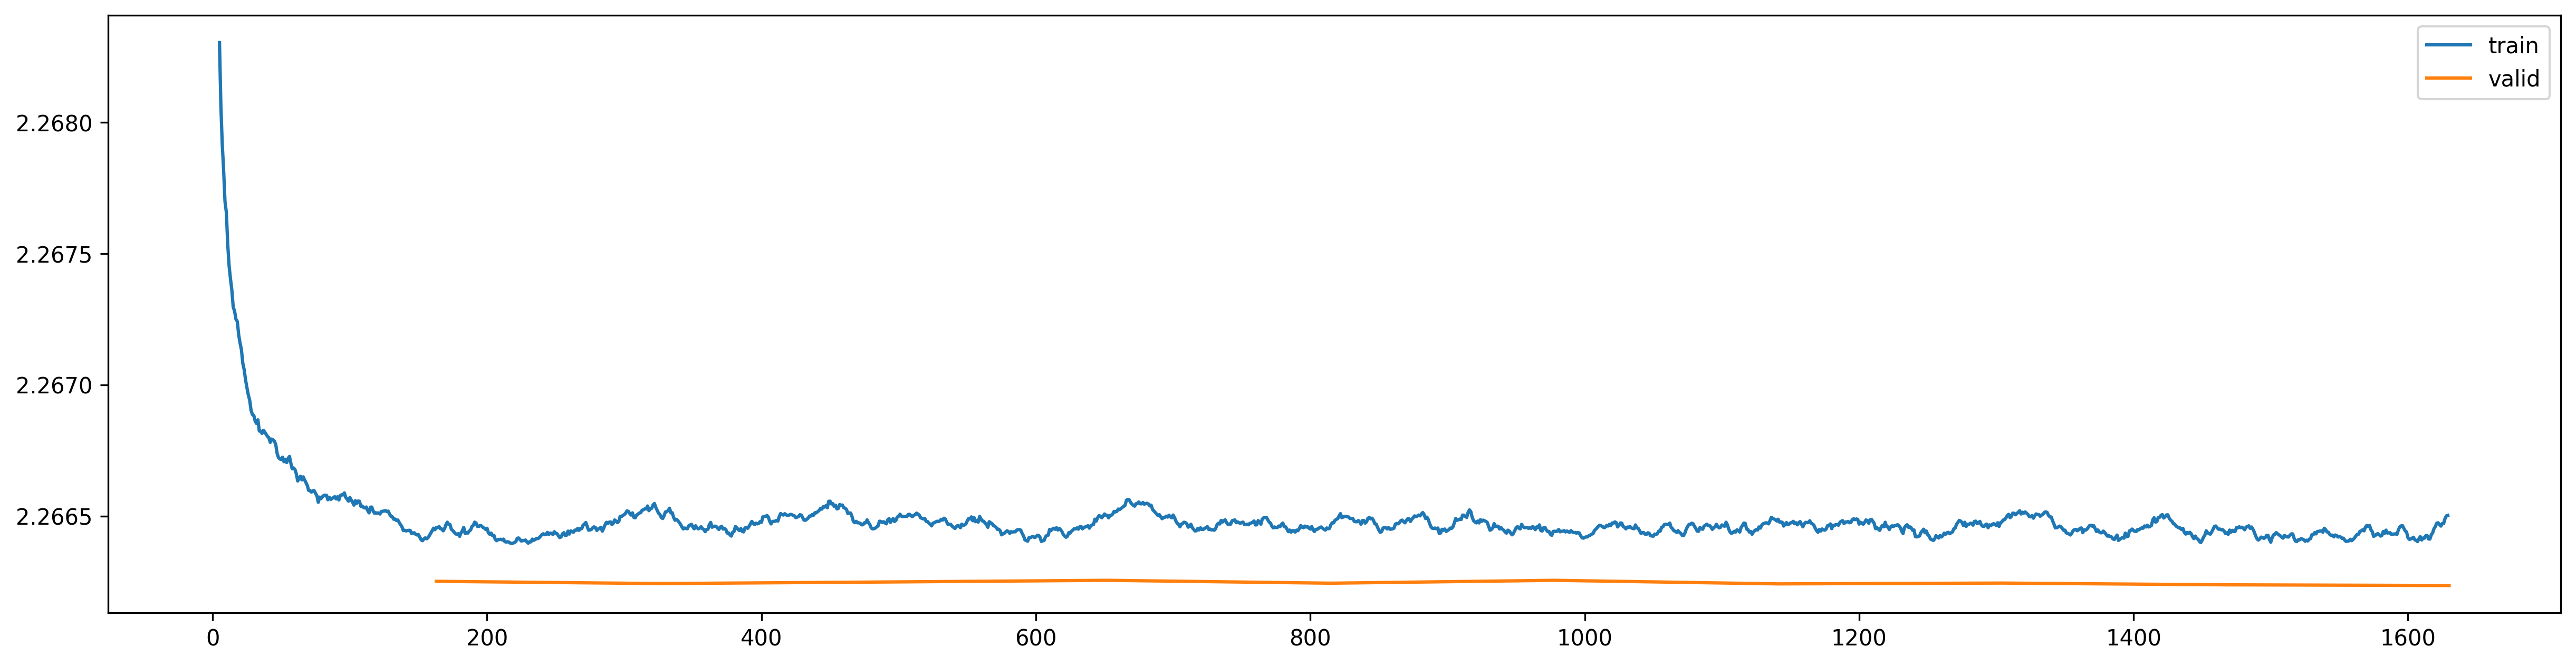

In [43]:
learn.recorder.plot_loss()

In [44]:
cv,_,time = learn.recorder.log[-3:];cv,_,time

(0.9423661185459941, 0.970048189163208, '01:58')

In [45]:
suffix =  '_synth'

In [46]:
modelname = f'lstm{model_params}_t{len(train_ds)}_v{len(valid_ds)}_BS{BS}_SS{SEGMENT_SIZE}_WS{WINDOW_SIZE}_FW{FEAT_WINDOW}_cv{cv:0.04f}{DATA_SUFFIX}{suffix}'
learn.save(modelname);modelname

'lstm6843915_t62500_v11250_BS384_SS500000_WS400_FW1_cv0.9424_clean_synth'

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
train_preds, valid_preds = learn.get_preds(0), learn.get_preds(1)
train_preds = train_preds[0][1],train_preds[1]
valid_preds = valid_preds[0][1],valid_preds[1]

In [ ]:
d_feats = train_preds[0].shape[-1]

In [ ]:
x0 = np.hstack((learn.model.fc._parameters['weight'].t().cpu().detach().numpy().flatten(),
                learn.model.fc._parameters['bias'].cpu().detach().numpy().flatten()))
x0.shape

In [ ]:
x0.shape

In [ ]:
#x,y = train_preds[0].view(-1,d_feats).cuda(),train_preds[1].view(-1).cuda()
x = y = None
gc.collect()
torch.cuda.empty_cache()
#x,y = valid_preds[0].view(-1,d_feats).cuda(),valid_preds[1].view(-1).cuda()
x,y = train_preds[0].view(-1,d_feats).cuda(),train_preds[1].view(-1).cuda()


In [ ]:
true   = y
evals = 0
max_evals = len(x0) 
print(max_evals)
imb = master_bar(range(max_evals), total=max_evals)
def adjust_thresholds(thresholds):
    global evals,imb
    m = Tensor(thresholds[:11*d_feats]).view(d_feats,11).cuda()
    b = Tensor(thresholds[11*d_feats:]).view(1,11).cuda()
    preds = (x @ m + b).argmax(dim=-1)
    
    y_pred = F.one_hot(preds,11)                    # S, C
    y_true = F.one_hot(true, 11).to(torch.float32)  # S, C
    
    tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

    precision = tp / (tp + fp )
    recall = tp / (tp + fn )

    f1 = 2* (precision*recall) / (precision + recall)
    f1 = f1.mean().cpu().numpy()

    if evals % 1000 == 0: print(f'{100*evals/max_evals:0.02f}% {f1:0.06f}')#, thresholds)
    evals += 1
    return 1-f1
    
def callback(xk):
    print(evals)
    return False if evals > max_evals else True

res = scipy.optimize.minimize(adjust_thresholds, x0,method='Powell', 
                              options={'disp':True, 'maxfev' : max_evals },
                              callback= callback)

In [ ]:
res.x

In [ ]:
x0 = res.x

In [ ]:
learn.model.fc._parameters['weight']

In [ ]:
learn.model.fc._parameters['weight'].data = Tensor(res.x[:11*d_feats]).view(d_feats,11).t().cuda()
learn.model.fc._parameters['bias'].data   = Tensor(res.x[11*d_feats:]).cuda()

In [ ]:
learn.model.fc._parameters['weight'],learn.model.fc._parameters['bias']

In [ ]:
class F1Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        super().__init__()
        self.d = data[0].shape[-1]
        self.x,self.y = data[0].view(-1,self.d),data[1].view(-1)
        self.n_inp = 1
    def __len__(self): return len(self.x)
    def __getitem__(self, idx): return self.x[idx].unsqueeze(1),self.y[idx]#.unsqueeze(-1)
    
f1_train_ds,f1_valid_ds = F1Dataset(train_preds), F1Dataset(valid_preds)
f1_train_dl = DataLoader(f1_train_ds, len(f1_train_ds)//100, shuffle=True,   num_workers=8, pin_memory=True)
f1_valid_dl = DataLoader(f1_valid_ds, len(f1_train_ds)//100, shuffle=False,  num_workers=8, pin_memory=True)

In [ ]:
d_feats = train_preds[0].shape[-1]

In [ ]:
f1model = nn.Sequential(nn.Conv1d(d_feats   , d_feats//2,3,1,1,groups=1), nn.ReLU(), 
                        nn.Conv1d(d_feats//2, d_feats//4,3,1,1,groups=1), nn.ReLU(), 
                        nn.Conv1d(d_feats//4 ,        11,3,1,1,groups=1),
                        Flatten())

In [ ]:
f1learn = None
gc.collect()
torch.cuda.empty_cache()
f1learn = Learner(DataLoaders(f1_train_dl,f1_valid_dl, device=default_device()),f1model,
                  loss_func=CrossEntropyLossFlat(),opt_func=Adam,
                  metrics=[F1Score(labels=list(range(11)),average='macro'), accuracy])
f1learn.summary()

In [ ]:
f1learn.fit(1,1e-3)

In [ ]:
f1learn.loss_func = softf1_loss

In [ ]:
f1learn.fit_one_cycle(20,5e-3)

In [ ]:
learn.model=learn.model.module

In [ ]:
learn.model

# Test

In [ ]:
learn.model.debug = True

In [57]:
test_ds

In [98]:
np.linspace(0,WINDOW_SIZE,endpoint=False)

array([  0.,   8.,  16.,  24.,  32.,  40.,  48.,  56.,  64.,  72.,  80.,
        88.,  96., 104., 112., 120., 128., 136., 144., 152., 160., 168.,
       176., 184., 192., 200., 208., 216., 224., 232., 240., 248., 256.,
       264., 272., 280., 288., 296., 304., 312., 320., 328., 336., 344.,
       352., 360., 368., 376., 384., 392.])

In [111]:
len(test_ds)

5000

In [114]:
test[0].squeeze().shape

torch.Size([20, 100000])

In [144]:
test_ds[0]

(tensor([[-1.0622],
         [-1.1392],
         [-1.1433],
         [-0.9794],
         [-1.0490],
         [-1.0299],
         [-1.0962],
         [-1.1121],
         [-1.1387],
         [-0.9566],
         [-1.1736],
         [-1.0515],
         [-1.1635],
         [-1.2457],
         [-1.2160],
         [-0.9824],
         [-1.0204],
         [-0.9636],
         [-1.2380],
         [-1.1568],
         [-1.0149],
         [-0.9714],
         [-0.9156],
         [-1.2014],
         [-1.1046],
         [-0.9171],
         [-0.9722],
         [-1.0376],
         [-1.0771],
         [-1.0817],
         [-1.0684],
         [-1.0197],
         [-1.0857],
         [-1.0774],
         [-0.9631],
         [-1.0703],
         [-1.0810],
         [-0.9038],
         [-1.0901],
         [-1.1584],
         [-0.9485],
         [-1.1394],
         [-1.0368],
         [-0.9473],
         [-1.2302],
         [-0.9565],
         [-1.0814],
         [-1.0368],
         [-1.1633],
         [-1.1287],


In [176]:
learn.model.eval()
test_preds  = torch.zeros(*test[0].squeeze().shape,11,dtype=torch.float)
test_preds_ = torch.empty_like(test_preds)
n_tta = 0
#learn.model = nn.DataParallel(learn.model)
with torch.no_grad():
    for shift in np.linspace(0,WINDOW_SIZE,endpoint=False,num=WINDOW_SIZE-1,dtype=np.int):
        test_dl.dataset.shift = shift
        test_preds_ = test_preds_.view(-1,11)
        test_preds_[...] = 0.
        s = 0
        for xx in progress_bar(test_dl):
            x = xx[0]
            preds = learn.model(x.cuda())
            open_channels,_ = preds
            open_channels = open_channels.view(-1,11)
            l = open_channels.shape[0]
            test_preds_[s:s+l] += open_channels.cpu()
            s += l
        test_preds_ = test_preds_.view(-1,TEST_SEGMENT_SIZE,11)
        ss = torch.arange(0+shift,TEST_SEGMENT_SIZE+shift) % TEST_SEGMENT_SIZE
        for segment in range(test_preds_.shape[0]):
            test_preds[segment,ss] += test_preds_[segment,...]
        n_tta +=1
#learn.model = learn.model.module

In [177]:
test_preds = test_preds.view(-1,11)
test_preds

tensor([[432.1927, -95.7989, -97.6549,  ..., -92.6171, -96.8991, -97.1827],
        [436.1508, -91.0960, -90.4951,  ..., -91.2605, -91.8153, -91.3312],
        [439.3098, -88.3902, -87.1730,  ..., -87.9764, -88.0281, -87.8786],
        ...,
        [446.7655, -80.5452, -80.5037,  ..., -80.6012, -80.7103, -80.6155],
        [447.1163, -80.2001, -80.1409,  ..., -80.2408, -80.3521, -80.2557],
        [447.5807, -79.7291, -79.6800,  ..., -79.7775, -79.8885, -79.7896]])

In [178]:
open_channels = test_preds.argmax(dim=1)
open_channels.shape

torch.Size([2000000])

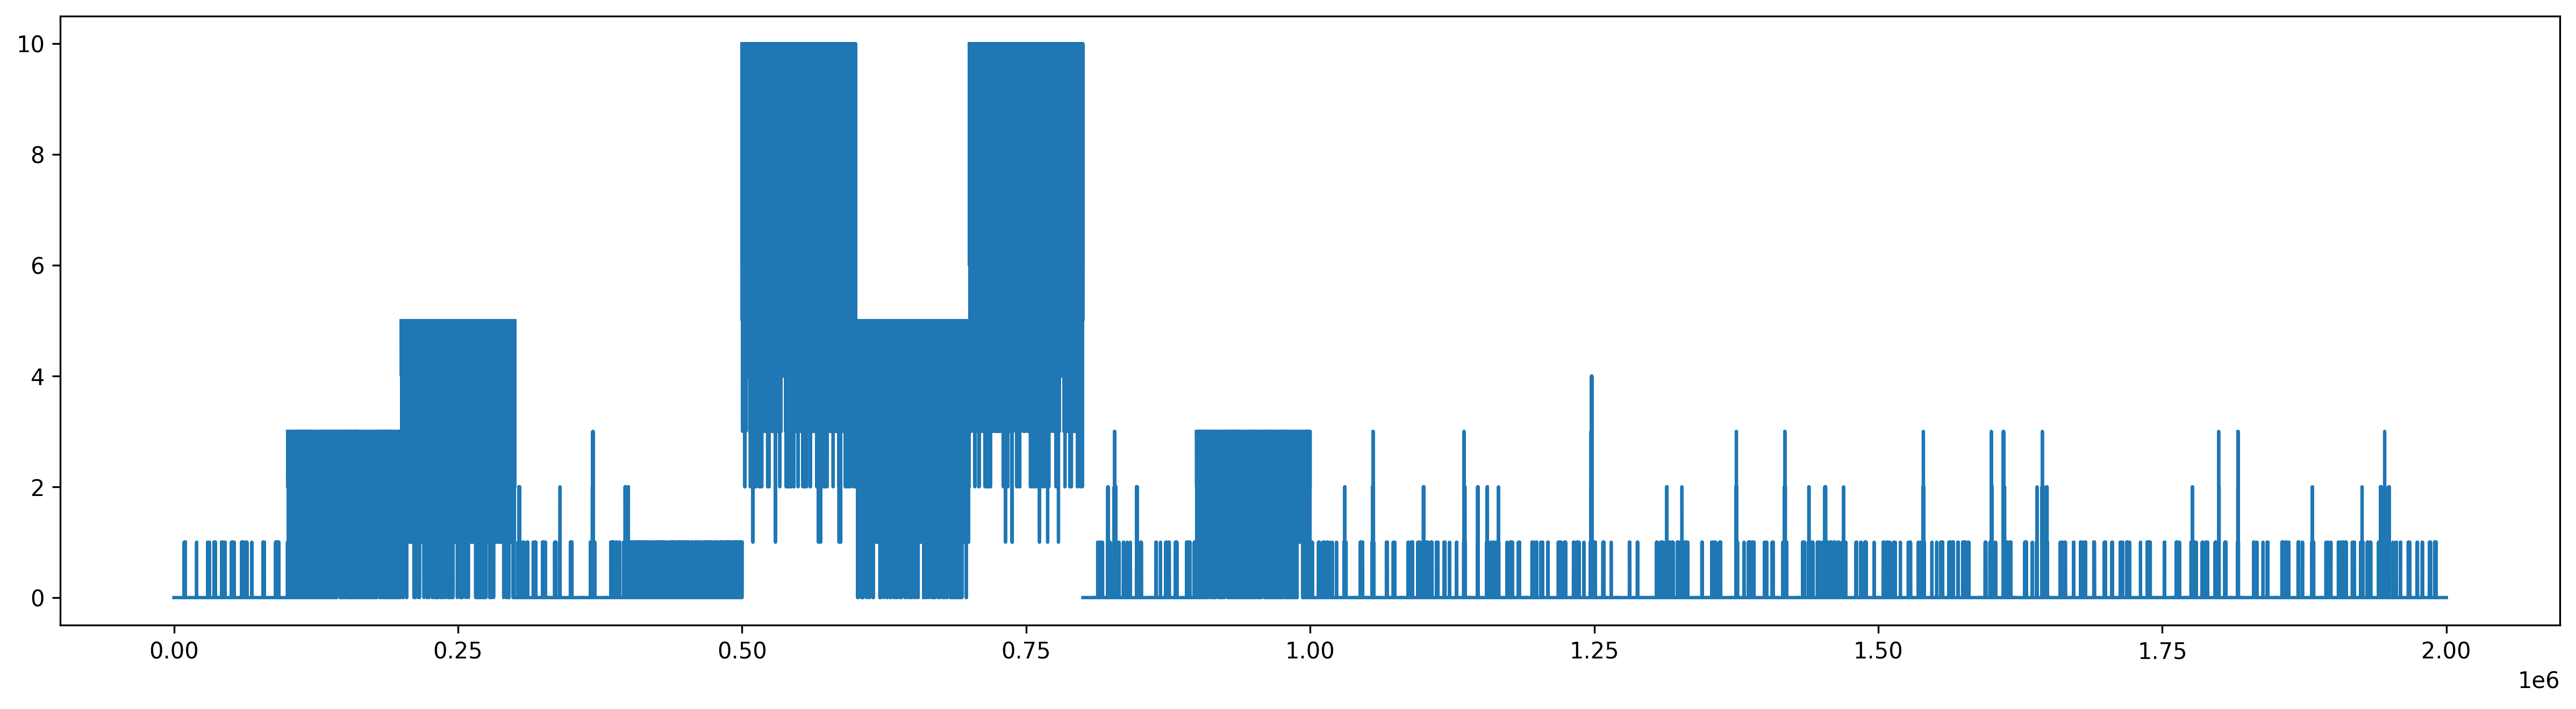

In [179]:
plt.plot(open_channels)

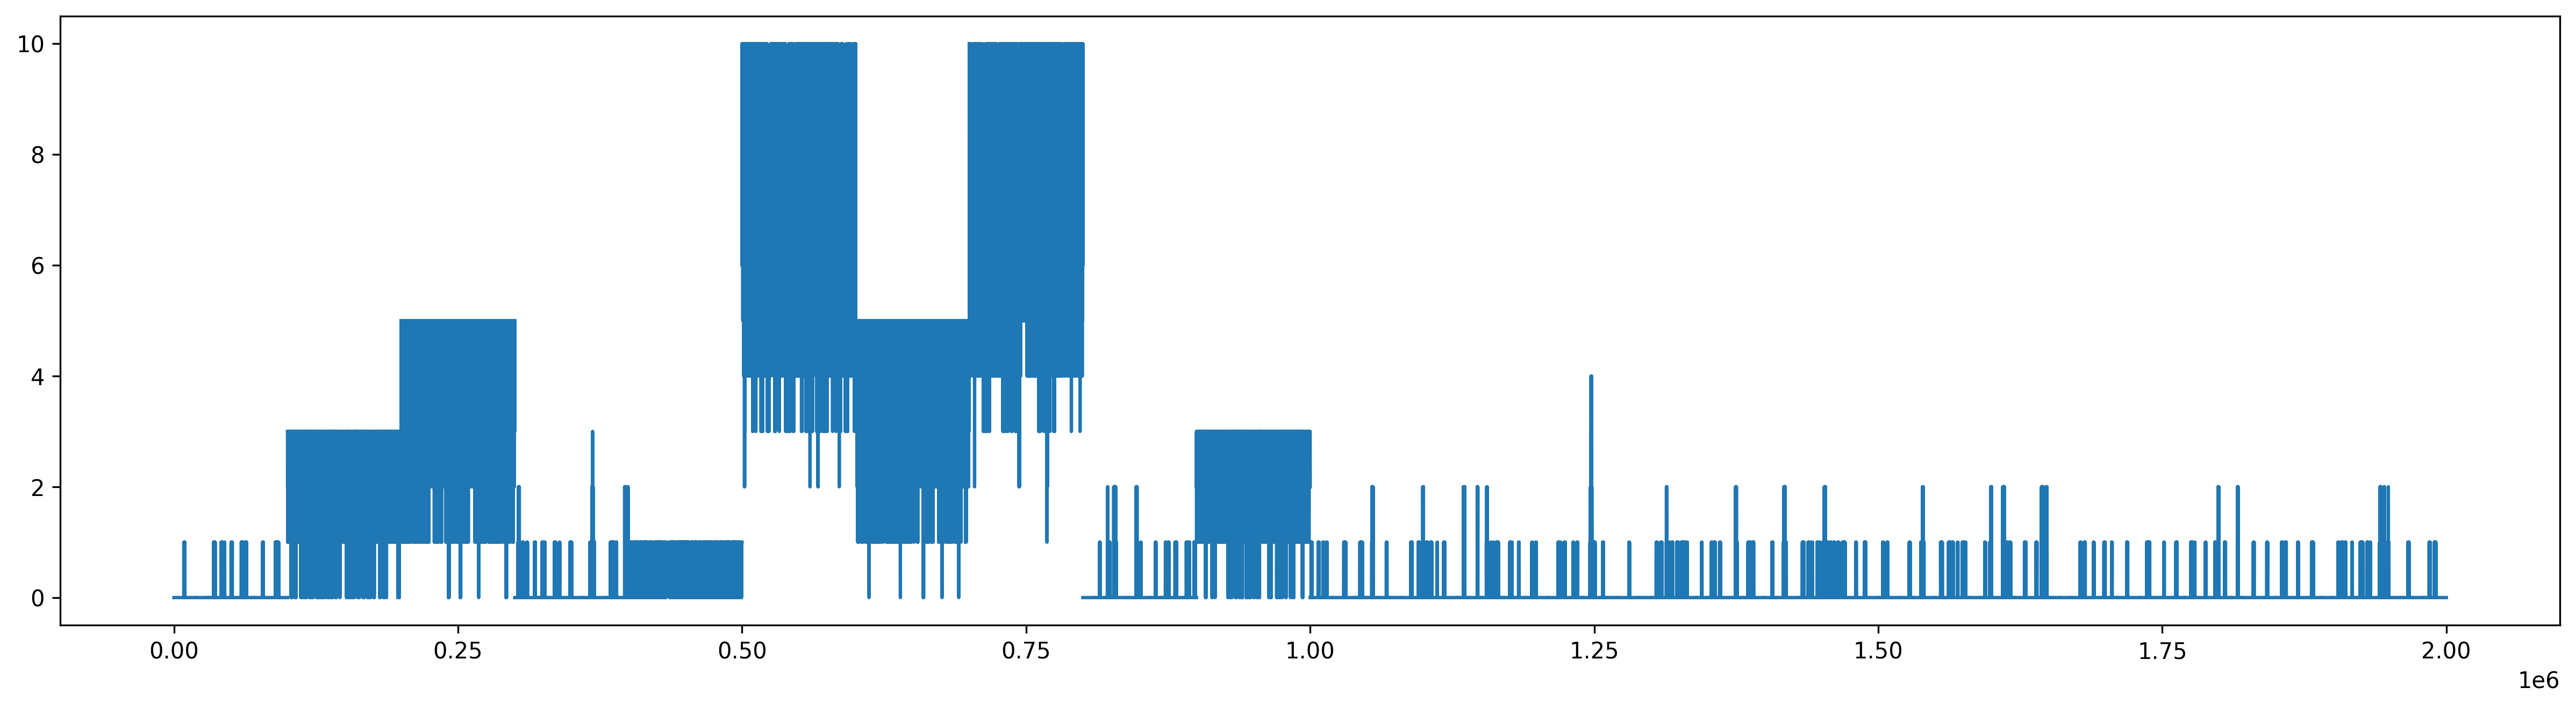

In [159]:
plt.plot(open_channels)

In [160]:
get_hist(open_channels.view(-1,100000).float())


NameError: name 'get_hist' is not defined

In [161]:
test[0,...,0].flatten().shape,open_channels.shape

(torch.Size([2000000]), torch.Size([2000000]))

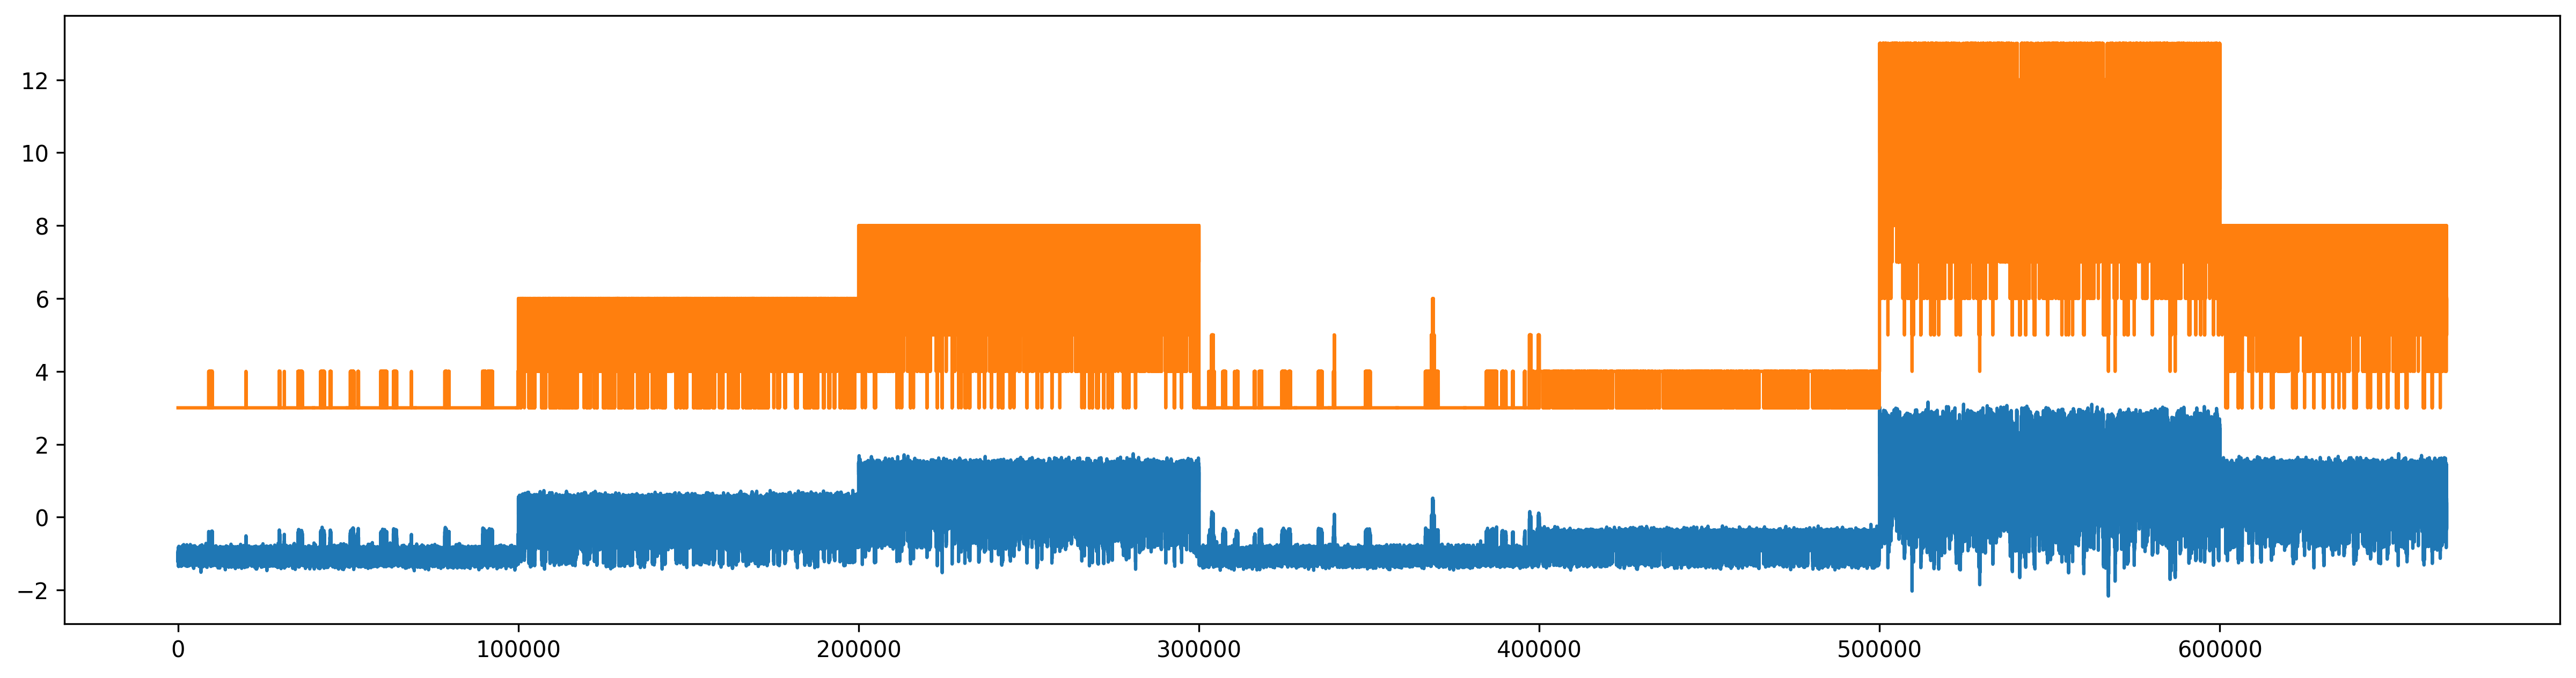

In [180]:
plt.plot(test[0,...,0].flatten()[:2000000//3])
plt.plot(open_channels[:2000000//3]+3)

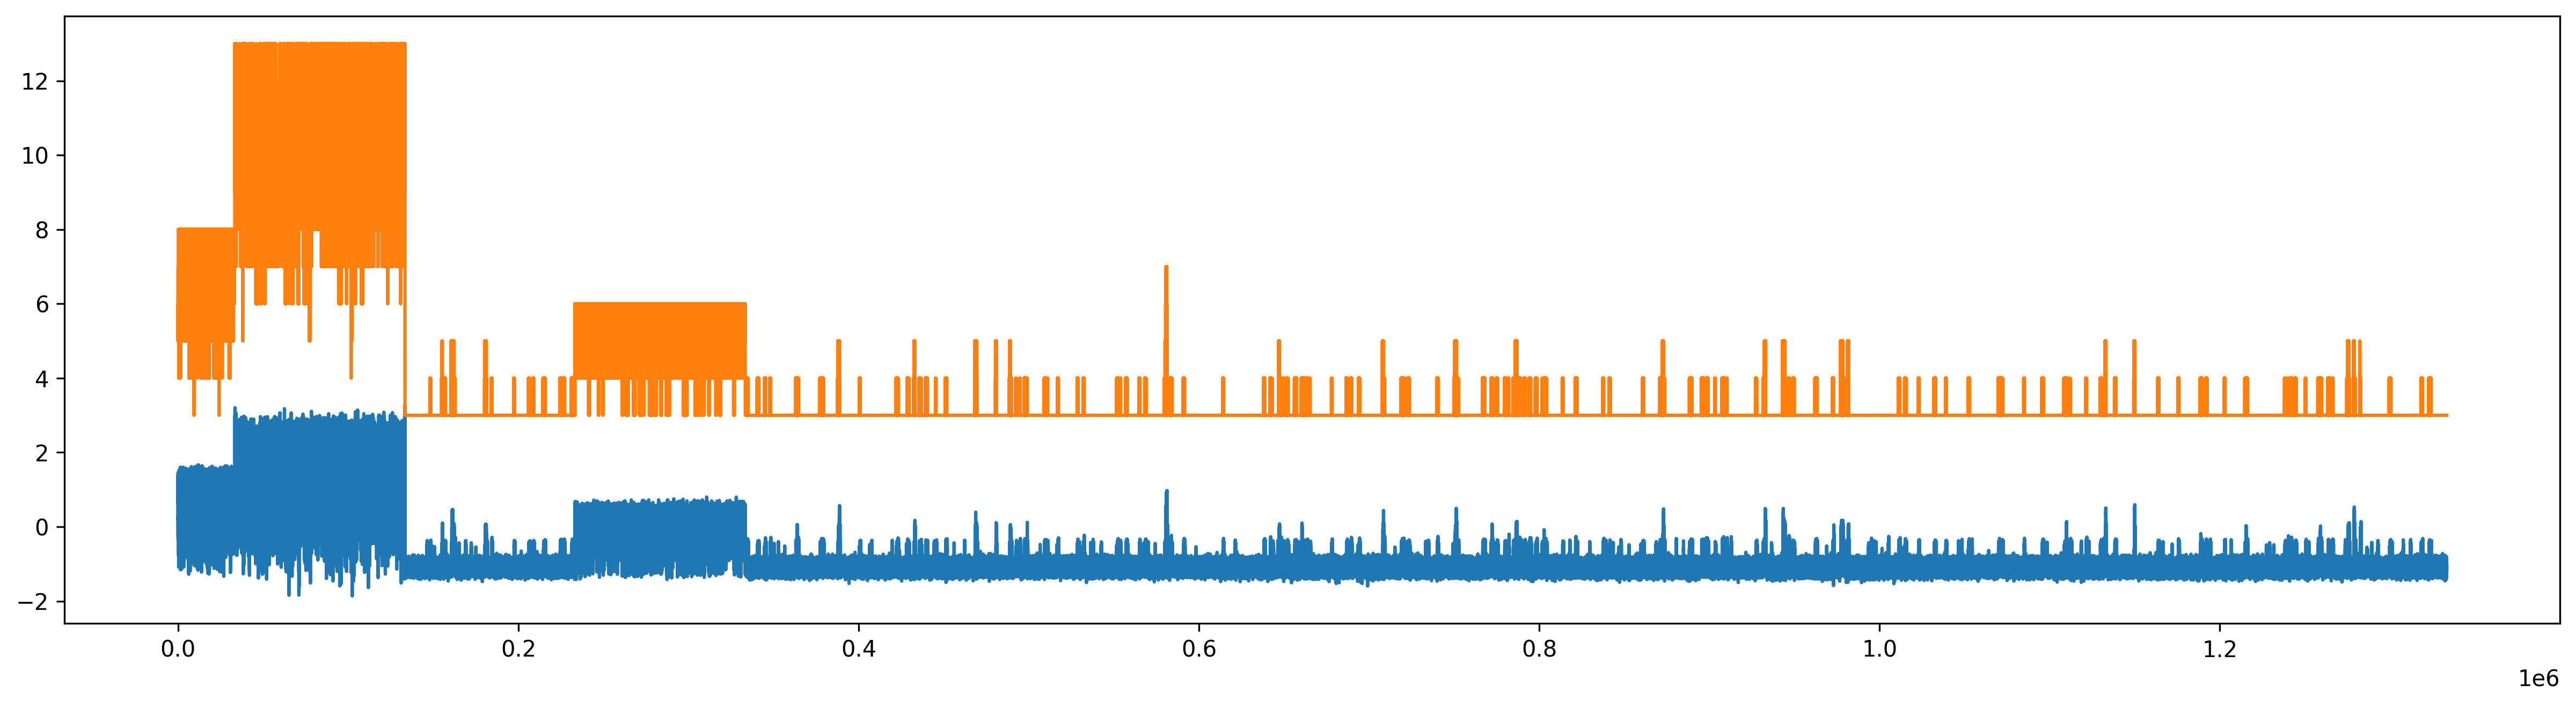

In [164]:
plt.plot(test[0,...,0].flatten()[2000000//3:])
plt.plot(open_channels[2000000//3:]+3)

In [181]:
csv_fname = f'{modelname}_n_tta{n_tta}.csv';csv_fname

'lstm6843915_t62500_v11250_BS384_SS500000_WS400_FW1_cv0.9424_clean_synth_n_tta399.csv'

In [182]:
submission_csv_path = p_input / 'sample_submission.csv'
ss = pd.read_csv(submission_csv_path, dtype={'time': str})
test_preds_all = test_preds
test_pred_frame = pd.DataFrame({'time': ss['time'].astype(str), 'open_channels': open_channels})
test_pred_frame.to_csv(csv_fname, index=False)

In [183]:
!kaggle competitions submit -c 'liverpool-ion-switching' -f {csv_fname} -m 'xtra {XTRA_DS}'

100%|██████████████████████████████████████| 21.0M/21.0M [00:03<00:00, 5.81MB/s]
403 - Your team has used its submission allowance (5 of 5). This resets at midnight UTC (8.6 hours from now).
